# Greeting
[u++](https://www.kaggle.com/sishihara/hypothesis-and-visualization-for-titanic-in-kaggle), Thank you!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import warnings
warnings.filterwarnings('ignore')

## Loading datasets
Check column item explanation on [Data Dictionary](https://www.kaggle.com/c/titanic/data)

`train.append(test)`でcsvをジョイント。

In [2]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
data = train.append(test) # The entire data: train + test.

# Features Engineering
[特徴エンジニアリング](https://docs.microsoft.com/ja-jp/azure/machine-learning/team-data-science-process/create-features). このプロセスは、データ内の既存の生の特徴から、関連する特徴を作成し、学習アルゴリズムの予測力を高めようとする。

## 1. Pclass ##
There is no missing value on this feature.

## 2. Sex ##
There is no missing value on this feature, but mapping is needed.

`str.replace(old, new[, count])`: `old`を`new`にする。

`train`変数: train.csvを読み込んだもの。

`test`変数: test.csvを読み込んだもの。

[`DataFrame`の引数`inplace`](https://note.nkmk.me/python-pandas-dataframe-rename/): 引数inplaceをTrueにすると、元のDataFrameが変更される。 

In [3]:
train['Sex'].replace(['male','female'],[0,1], inplace=True)
test['Sex'].replace(['male','female'],[0,1], inplace=True)

## 3. Embarked
Embarked feature has some missing values, filled with the most occurred value ( 'S' ).

[`fillna()`メソッド](https://note.nkmk.me/python-pandas-nan-dropna-fillna/): 欠損値を他の値に置換（穴埋め）する.
[`map()`の引数に辞書を指定](https://note.nkmk.me/python-pandas-map-replace/): `map()`の引数に辞書`dict（{key: value}）`を指定すると、`key`と一致する要素が`value`に置換.

In [4]:
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train['Embarked'] = data['Embarked'][:len(train)]
test['Embarked'] = data['Embarked'][len(train):]

## 4. Fare ##
Fare also has some missing value and replaced them with mean, and categorized into 4 ranges.
[`np.mean`](https://deepage.net/features/numpy-average.html#npmean): 純粋に要素の平均を求める. つまり、`Fare`の欠損値は平均で埋める、ということ。

In [5]:
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)
data['Categorical_Fare'] = pd.qcut(data['Fare'], 4, labels=False)

train['Categorical_Fare'] = data['Categorical_Fare'][:len(train)]
test['Categorical_Fare'] = data['Categorical_Fare'][len(train):]

## 5. Age ##
There are plenty of missing values in this feature. Generate random numbers between (mean - std) and (mean + std), categorized into 5 range.

- `numpy.mean()`: 平均
- `.std()`: 配列に含まれる要素のデータの散らばり具合を示す指標の１つとなる標準偏差を求める。
- `pd.cut()`: ビニング処理（ビン分割）。連続値を任意の境界値で区切りカテゴリ分けして離散値に変換する処理のこと。機械学習の前処理として行われることが多い。値を元にビン分割。最大値と最小値の間を等間隔で分割し、境界値を指定して分割する。

### 平均から標準偏差を求める流れとなる
- 標準偏差: 標準偏差を求めるには、分散（それぞれの数値と平均値の差の二乗平均）の正の平方根を取ります。 データが平均値の周りに集中していれば標準偏差は小さくなり、逆に平均値から広がっていれば標準偏差は大きくなります。
- 偏差 = 個人の点数 - 平均点。偏差が大きくなればなるほど平均から外れている。偏差の平均値を取れば、全体が平均からどれだけずれているかがわかる。
- 偏差の問題点: 平均値からどれほど離れているのかを数字で表した偏差ですが、偏差は偏差の平均を取ると常に０になってしまうのです。偏差には、プラスとマイナスの値がそれぞれ出現し、平均を取るとこれらがお互いに打ち消しあい、すべて加えると０になってしまうというわけです。
- 偏差の問題点を解決する偏差平方: 偏差 ** 2 = {(自分の取った点) - (平均点)} ** 2。これで負の数が正の数になる。
- 分散の問題点1: 平方をすると数値が大きくなりすぎる。
- 分散の問題点2: 偏差を平方したことで単位が変わってしまう。
- 分散の問題点を解決するのが標準偏差。 `math.sqrt('分散')`。分散の平方根を取る。

### 乱数の生成
`random.randint(age_avg - age_std, age_avg + age_std)`は平均マイナス標準偏差で最低ラインの年齢、平均プラス標準偏差で上位ラインの年齢の間で乱数を生成させる。

### 参考リンク
- [nkmk](https://note.nkmk.me/python-numpy-ndarray-sum-mean-axis/)
- [平均から偏差までの流れを追う](https://tinyurl.com/y7u648lf)

In [6]:
age_avg = data['Age'].mean()
age_std = data['Age'].std()

data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
data['Categorical_Age'] = pd.cut(data['Age'], 5, labels=False)

train['Categorical_Age'] = data['Categorical_Age'][:len(train)]
test['Categorical_Age'] = data['Categorical_Age'][len(train):]

## 6. Name ##
Inside this feature, there are titles of people.

- pandasで要素、行、列に関数を適用する。Pythonの組み込み関数、無名関数（lambda）やdefで定義した関数をmap()またはapply()の引数に渡す。

### 参考サイト
- [pandasで要素、行、列に関数を適用するmap, applymap, apply](https://note.nkmk.me/python-pandas-map-applymap-apply/)

In [20]:
# Dropping Title feature
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

data['Title'] = data['Name'].apply(get_title)

data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)

data['Title'].replace(['Mlle','Ms','Mme'],['Miss','Miss','Mrs'], inplace=True)

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data['Title'] = data['Title'].map(title_mapping)
data['Title'].fillna(0, inplace=True)
print(data['Title'][0:10])

0    1
1    3
2    2
3    3
4    1
5    1
6    1
7    4
8    3
9    3
Name: Title, dtype: int64


## Data Cleaning ##
`pandas.DataFrame`の行・列を指定して削除するには`drop()`メソッドを使う。
- `axis = 0`で行を削除
- `axis = 1`で列を削除

### 参考サイト
- [pandas.df.drop](https://note.nkmk.me/python-pandas-drop/)

In [8]:
delete_columns = ['Fare', 'Age', 'Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
train.drop(delete_columns, axis = 1, inplace = True)
test.drop(delete_columns, axis = 1, inplace = True)

In [9]:
train.head()

,Survived,Pclass,Sex,Embarked,Categorical_Fare,Categorical_Age
0,0,3,0,0,0,1
1,1,1,1,1,3,2
2,1,3,1,0,1,1
3,1,1,1,0,3,2
4,0,3,0,0,1,2


In [10]:
test.head()

,Pclass,Sex,Embarked,Categorical_Fare,Categorical_Age
0,3,0,2,0,2
1,3,1,0,0,2
2,2,0,2,1,3
3,3,0,0,1,1
4,3,1,0,1,1


# Classification #

 - **Creating X and y**

In [11]:
X = train.drop('Survived', axis = 1)
y = train['Survived']
X_test = test.copy()

 - **Scaling features**
   - `sklearn.preprocessing.StandardScaler`: 標準化して特徴量の尺度を揃えるために使う。
   - `fit_transform()`: `StandardScaler`モジュールで使えるメソッド。パラメータ計算とデータ変換をまとめて実行する。
 - **参考サイト**
   - [sklearn StandardScaler で標準化の効果を確かめる－python](http://ailaby.com/scaler/)

In [12]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

## Grid Search CV ##
 
 Here I use KNN.
 
 - KNN: k近傍法 (k-Nearest Neighbor algorithm)。機械学習において教師あり学習で分類問題を解くためのアルゴリズム。
 - `range(start, stop, step)`
 
- ハイパーパラメータ: 機械学習のアルゴリズムにおいて、人が調整する必要のあるパラメータ。 自動では決められないので、色々な値を試したりして汎化性能が高くなるものを選ぶ。
- sklearnの`GridSearchCV`: あらかじめいくつか候補を与えることで、その中から汎化性能が高くなるものを選んでくれる。
- `KNeighborsClassifier`: あるデータのクラスを分類する際に, そのデータから距離が近い順にK個訓練集合からデータを取り出し, それらのラベルの投票によって分類対象のラベルを決定するシンプルなアルゴリズム。
- `best_estimator_`: 最もよかった際の学習のパラメータが表示できます。


 ### 参考サイト
 - [Python: k 近傍法を実装してみる](https://blog.amedama.jp/entry/2017/03/18/140238)
 - [Python: scikit-learn のハイパーパラメータを GridSearchCV で最適化する](https://blog.amedama.jp/entry/2017/09/05/221037)
 - [scikit.learn手法徹底比較！ K近傍法編](http://d.hatena.ne.jp/saket/20130213/1360747549)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = list(range(5,20,1))
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors} # 辞書
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=10)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1220 tasks      | elapsed:    4.4s


0.8573185285405527
KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')


[Parallel(n_jobs=10)]: Done 3000 out of 3000 | elapsed:    8.6s finished


 - **Using a model found by grid searching**
 - グリッドサーチ: 機械学習モデルのハイパーパラメータを自動的に最適化してくれる
 
 ### 参考サイト
 - [Scikit learnより グリッドサーチによるパラメータ最適化](https://qiita.com/yhyhyhjp/items/c81f7cea72a44a7bfd3a)

In [14]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(test)

- **Making submission**

In [22]:
temp = pd.DataFrame(pd.read_csv("./input/test.csv")['PassengerId'])
temp['Survived'] = list(map(int, y_pred))
temp.to_csv("submission.csv", index = False)

# New Feature Creation #

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

Create new feature called Family Size, just Parch + SibSp.

In [26]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

train['Family_Size'] = data['Family_Size'][:len(train)]
test['Family_Size'] = data['Family_Size'][len(train):]

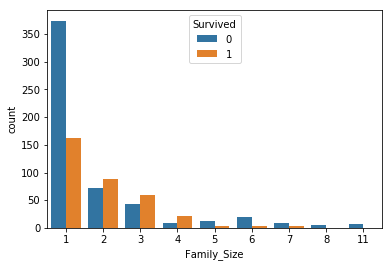

In [27]:
sns.countplot(x='Family_Size', data = train, hue = 'Survived')

You can see 2 findings:
1. Family_Size >= 5 may also lead to bad survival rate.
1. Family_Size == 1 may lead to bad survival rate.

In [ ]:
X = train.drop('Survived', axis = 1)
y = train['Survived']
X_test = test.copy()

- `StandardScaler()`: 標準化に使う。統計学における標準化 (standardization) とは，与えられたデータを平均が0で分散が1のデータに変換する操作のことをいう．正規化とか規格化とも呼ばれる．
- `fit_transform()`: fit()を実施した後に、`transform()`を実施。
- `transform()`: fit()で取得した統計情報を使って、渡されたデータを実際に書き換える。
### 参考サイト
- [scikit-learn の fit() / transform() / fit_transform()](https://qiita.com/makopo/items/35c103e2df2e282f839a)

In [ ]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [ ]:
n_neighbors = list(range(5,20,1))
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

In [ ]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(test)

In [ ]:
temp = pd.DataFrame(pd.read_csv("../input/test.csv")['PassengerId'])
temp['Survived'] = list(map(int, y_pred))
temp.to_csv("submission_add_family_size.csv", index = False)

Let's go further and categorize people to check whether they are alone in this ship or not.

In [ ]:
data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

In [ ]:
X = train.drop('Survived', axis = 1)
y = train['Survived']
X_test = test.copy()

In [ ]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [ ]:
n_neighbors = list(range(5,20,1))
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=10)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

In [ ]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(test)

In [ ]:
temp = pd.DataFrame(pd.read_csv("../input/test.csv")['PassengerId'])
temp['Survived'] = list(map(int, y_pred))
temp.to_csv("submission_add_family_size_and_isalone.csv", index = False)